In [2]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

from scipy import linalg
import scipy.io as sio

from pynfft import NFFT

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(img0)
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(img1)
    sub1.set_title(title1)
    
y = sio.loadmat("export_mat/y.mat")['y'][0,0].reshape(307780)
p = np.asarray(sio.loadmat("export_mat/p.mat")["p"])
dirty = np.asarray(sio.loadmat("export_mat/dirty.mat")["dirty"])

p_shaped = np.reshape((0.5)*p, (p.shape[0]*p.shape[1]))
dim = (64,64)
plan = NFFT(dim, y.size)
plan.x = p_shaped
plan.precompute()

plan_forward = NFFT(dim, y.size)
plan_forward.x = p_shaped
plan_forward.precompute()

In [3]:
plan.f = np.ones(y.shape)
psf_map = np.real(plan.adjoint()).copy()
psf_map= psf_map / psf_map.sum()

plan.f = y
dirty_map = np.real(plan.adjoint()).copy()

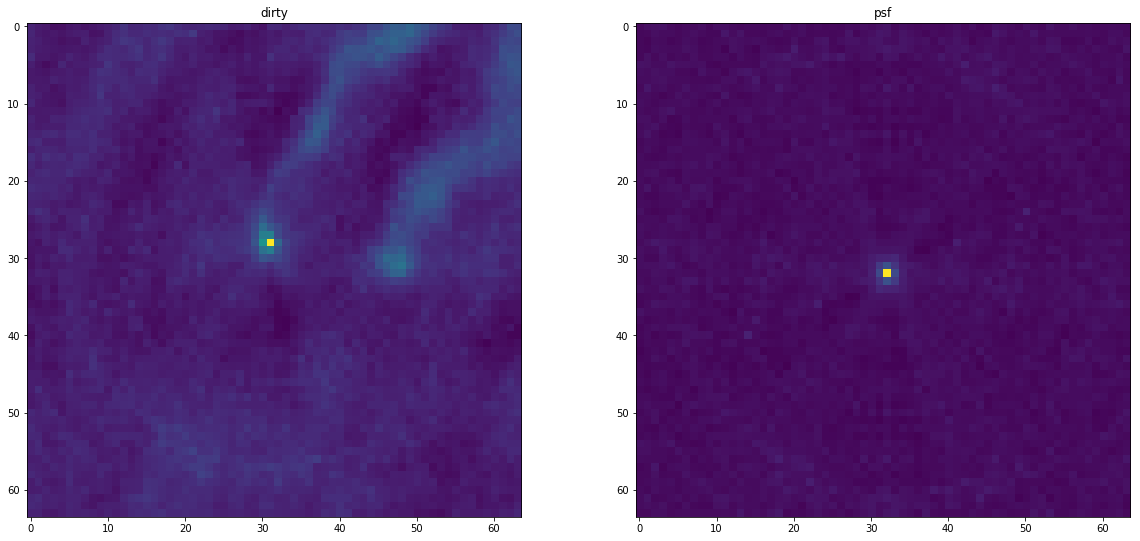

In [4]:
plot_comparison(dirty_map, 'dirty', psf_map, "psf")

In [4]:
def calcSpline():
    b3spline = np.asarray([1.0 / 16.0, 1.0 / 4.0, 3.0 / 8.0, 1.0 / 4.0, 1.0 / 16.0])

    row = np.asmatrix([b3spline])
    bla = (np.dot(np.transpose(row), row))
    return (np.dot(np.transpose(row), row))

def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0] * size[1], size[0] * size[1]))
    kernel = np.fliplr(np.flipud(kernel))

    disp = 2 ** J
    mid = kernel.shape[0] // 2
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            temp = np.reshape(output[offset + y], size)
            for i in range(0, kernel.shape[0]):
                for j in range(0, kernel.shape[1]):
                    xi = ((i - mid) * disp + x)
                    yi = ((j - mid) * disp + y)
                    # print(xi, yi)
                    mx = xi // size[0] % 2
                    xi = xi % size[0]
                    if mx == 1:
                        xi = size[0] - 1 - xi

                    my = yi // size[1] % 2
                    yi = yi % size[1]
                    if my == 1:
                        yi = size[1] - 1 - yi
                    # print(mx, my, xi, yi)
                    temp[xi, yi] += kernel[i, j]
    return (output)

In [123]:
from scipy import linalg

def soft_thresh(x, l):
    x2 = np.sign(x) * np.maximum(np.abs(x) - l, 0.)
    return x2[x2 < 0.0] = 0

def prep_starlet_base(img_dim):
    b3spline = calcSpline()
    starlets = [
        calcConvMatrix(img_dim, b3spline, 0),
        calcConvMatrix(img_dim, b3spline, 1),
        calcConvMatrix(img_dim, b3spline, 2),
    ]
    return starlets

def to_starlets(x, starlet_base):
    last_c = x
    
    alpha = np.zeros((x.size, len(starlet_base)+1))
    for i in range(len(starlet_base)):
        c = np.dot(starlet_base[i], last_c)
        w = last_c - c
        alpha[:, i] = w
        last_c = c
        
    alpha[:, len(starlet_base)] = last_c
    return alpha

def from_starlets(starlets):
    return np.sum(starlets, axis=1)
    
    
def fista(V, img_dimension, lambda_cs, maxit):
    starlet_base = prep_starlet_base((64, 64))
    
    x_old = np.zeros((img_dimension, len(starlet_base)+1))
    #x_old = np.zeros(img_dimension)
    x = x_old.copy()
    alpha = x_old.copy()
    
    t=0
    t_new = 0
    mu = 0
    for M in starlet_base:
        mu = mu + linalg.norm(M) ** 2
    mu = 1 / (mu*5000)
    
    for _ in range(maxit):
        #forward
        x_old = x.copy()
        plan_forward.f_hat = np.sum(alpha, axis=1)
        Vdiff = V - plan_forward.trafo().copy()
        
        print(np.abs(Vdiff).sum())
        #backward
        plan.f = Vdiff
        beta = x + mu * to_starlets(np.real(plan.adjoint().copy().flatten()), starlet_base)
        
        x = soft_thresh(beta, mu*lambda_cs)
        t_new = (1.0 + math.sqrt(1.0 + 4.0 * t * t)) / 2.0
        gamma = (t - 1.0) / t_new
        alpha = x + gamma *(x - x_old)
        t = t_new
        
    return np.sum(alpha, axis=1)

SyntaxError: invalid syntax (<ipython-input-123-a9901324955a>, line 5)

In [128]:
res = fista(y, (64*64), 10000.0, 50)

889752.7063039179
889752.7063039179
802093.411357403
779174.0734008981
765628.8896601034
755732.7548759902
748064.0712119053
741814.9651251679
736822.7917038724
732799.341620852
729513.4002004613
726826.2808160499
724611.7905886609
722719.776368902
721157.1847502246
719852.4279897434
718735.2508101042
717739.9875437318
716978.3027828946
716339.750550805
715758.0032823414
715231.2212168633
714800.3304634239
714381.7067451205
714045.9885115335
713755.3623832235
713517.7816277775
713294.8911503316
713123.6227695293
712968.8662274171
712843.5439703943
712731.7659563549
712642.3218228198
712553.4415397503
712482.2014111766
712435.093214187
712403.6071903212
712380.1070421813
712347.5419932752
712339.4833099836
712340.211090802
712349.0682927261
712358.5097647598
712376.1518170321
712382.1964642915
712400.2958249373
712418.7217995562
712439.7730414739
712451.4338845963
712474.8346097159


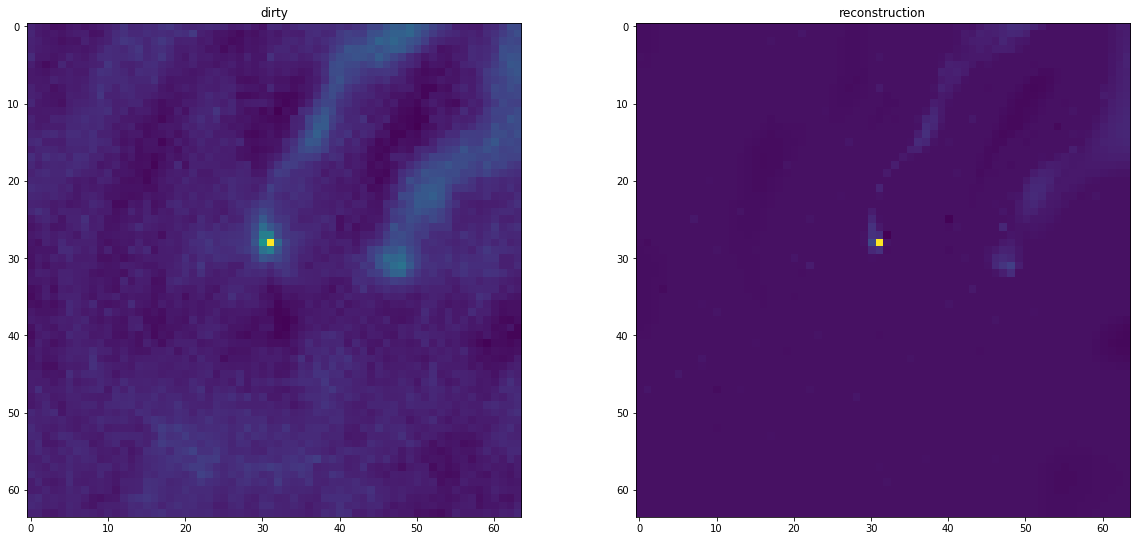

In [133]:
plot_comparison(dirty_map, 'dirty', res.reshape(64,64), "reconstruction")

In [132]:
np.max(res)

1.1451381343085643

In [6]:
V = y
img_dimension = (64 * 64)
lambda_cs = 0.01
maxit = 5

starlet_base = prep_starlet_base((64, 64))

x_old = np.zeros((img_dimension, len(starlet_base)+1))
x = x_old.copy()
x_new = x_old.copy()
alpha = x_old.copy()

t=0
t_new = 0
mu = 0
for M in starlet_base:
    mu = mu + linalg.norm(M) ** 2
mu = 1 / math.sqrt(mu)



plan2.f_hat = np.sum(alpha, axis=1)
V2 = plan2.trafo().copy()
Vdiff = V - V2



In [7]:
plan.f = Vdiff
img = plan.adjoint().copy()

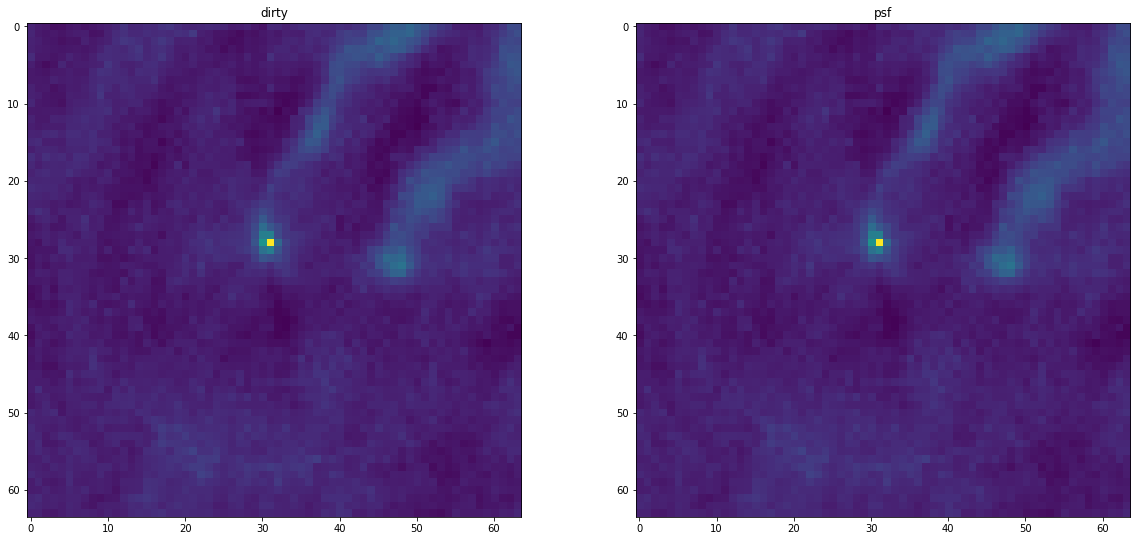

In [8]:
plot_comparison(dirty_map, 'dirty', np.real(img), "psf")